# Esercitazione 10
### Laboratorio di Simulazione Numerica

Il materiale relativo all'esercitazione dieci è contenuto nella cartella `Lab_10` e suddiviso in codice, raccolto in `Code/10.1, 10.2` e risultati, raccolti in `Results`.

---

La struttura del Jupyter Notebook è la seguente:
- 10.0 caricamento dei pacchetti e introduzione;
- 10.1 il problema del commesso viaggiatore (TSP) e l'algoritmo di _simulated annealing_ (SA);
- 10.2 risoluzione del TSP tramite algoritmo genetico e parallelizzando il codice.

## 10.0 - caricamento dei pacchetti e introduzione

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=1.7, style='whitegrid')

In [2]:
cities_circ = np.loadtxt("Results/circle_circuit.dat")
chromo1_circ = np.loadtxt("Results/circle_ini.dat", dtype='int')
chromo2_circ = np.loadtxt("Results/circle_fin.dat", dtype='int')
ann_cir = np.loadtxt("Results/anneal_circle.dat")

In questa esercitazione affrontiamo due aspetti importanti nella risoluzione di problemi di ottimizzazione:
- non esiste un solo modo per affrontare il problema: gli algoritmi genetici e il simulated annealing sono strumenti diversi utilizzati con lo stesso obiettivo;
- quando si affrontano problemi di ottimizzazione è importante conoscere le potenzialità della parallelizzazione. Utilizzando i GAs, per esempio, si svolgono numerose azioni indipendenti (selezione degli individui dalla popolazione, mutazioni, eccetera) e, potendo suddividere i compiti da svolgere su un numero maggiore di processori ci permette di risparmiare complessità in tempo.

## 10.1 - simulated annealing e commesso viaggiatore

__NB:__ in questa esercitazione gli operatori (i metodi negli algoritmi) sono gli stessi utilizzati nell'esercitazione 9.

---

Con _simulated annealing_ indichiamo una tecnica di ricerca della soluzione ottimale ad un problema di ottimizzazione che sfrutta un campionamento "alla Metropolis" nello spazio delle soluzioni per cercare il candidato migliore. Nel SA si implementa un graduale raffreddamento del sistema, posto all'inizio del processo ad una temperatura fittizia arbitraria. Nel mio caso, ho deciso di spostare la temperatura del sistema operando sulla $\beta$, che ho fatto avanzare di passi unitari nell'intervallo $\beta \in [1,500]$ (in questo modo è stato più semplice implementare i raffreddamenti). Questo progressivo raffreddamento fittizio ci consente di costruire un algoritmo in cui il rate di accettazione delle modifiche alla soluzione diminuisce sempre di più, passando da una ricerca  più frenetica iniziale ad un progressivo rallentamento delle modifiche. Verso la fine dell'esecuzione, il sistema opera variazioni della soluzione molto raramente. In termini più pratici, l'impatto che il raffreddamento comporta sull'accettazione di nuovi passi della catena lo vediamo esplicitamente nella forma della matrice di accettazione della nuova configurazione $\nu$ a partire da quella vecchia $\mu$:

$$\alpha= A(\mu\to\nu) = \min \bigl[ 1, e^{-\beta \Delta E} \bigr], $$

dove $\Delta E = E_{\nu}-E_{\mu}$ è definito come la differenza delle funzioni di costo con cui valutiamo la bontà della soluzione nuova e di quella vecchia. Per costruzione, questa scelta di $A$ ci consente di eseguire aggiornamenti con probabilità 1 quando $E_{\nu}<E_{\mu}$ e con probabilità $e^{-\beta \Delta E}$ altrimenti. Inoltre, all'aumentare della $\beta$ all'esponente (dunque al diminuire della temperatura), la probabilità con cui i nuovi passi vengono accettati diminuisce intrinsecamente. 

---

Per descrivere dal punto di vista pratico il mio algoritmo è necessario sottolineare che, per questo esercizio, ho dovuto modificare leggermente la struttura del codice costruita nella scorsa esercitazione. Non è più necessario utilizzare un'intera popolazione di individui: ho sostituito come data membri della classe `Salesman` i due vettori a `Chromo` (che erano `_pop[]` e `_son[]`) con due soli cromosomi: `_old_chromo` e `_new_chromo`. A questo punto ho scritto il metodo `simulated_annealing(betai, betaf, Nstep, Nmoves, ...)` che opera nel modo seguente:

1. Viene impostato il valore iniziale di $\beta$: `beta = betai` 
2. Per `Nstep` volte:
    1. `beta += dbeta`, con `dbeta` dato da differenza tra valore finale e iniziale fratto `Nstep`;
    2. per `Nmoves` volte:
        1. copio il cromosoma vecchio in quello nuovo; 
        2. provo ad applicare la sequenza di quattro mutazioni (le stesse dell'esercitazione nove, con solita probabilità $p_m=0.06$) al cromosoma nuovo;
        3. calcolo le energie dei cromosomi vecchio e nuovo tramite il metodo `eval_fitness()`;
        4. calcolo la probabilità di transizione come visto in precedenza e accetto il passo con quella stessa probabilità $\alpha$;
        
---

Ho eseguito la ricerca della soluzione ottimale in due situazioni diverse: 
- considerando 32 città disposte casualmente lungo una circonferenza di raggio unitario;
- considerando 32 città disposte caualmente all'interno di un quadrato di lato unitario;

In entrambi i casi ho eseguito l'algoritmo di SA in questo modo: `simulated_annealing(1, 500, 500, 100)`. In pratica ho eseguito `Nstep = 500` passi costanti in cui $\beta \in [1,500]$. Per ciascuna temperatura ho proposto `Nmoves = 100` modifiche al cromosoma. In ciascuno dei due casi ho perciò eseguito $N_{sa} = 5\cdot 10^4$ passi genetici.

Volendo fare un confronto con l'algoritmo genetico, bisogna considerare che in quel caso ho eseguito trecento ricambi generazionali, $N_{gen}=300$. Ogni nuova generazione è composta da mille individui, su ciascuno dei quali ho tentato la mutazione genetica. In totale, dunque, ho eseguito $N_{ga} = 3 \cdot 10^5$ passi genetici. Considerando che i risultati ottenuti in questa sede sono paragonabili a quelli ricavati nell'esercitazione nove, mi sento di affermare che l'algoritmo più efficace per risolvere questo problema è il SA.

### Sulla circonferenza

In [3]:
x_first = [] 
y_first = []

for i in range(len(chromo1_circ)):
    x_first.append(cities_circ.T[0][chromo1_circ[i]-1])
    y_first.append(cities_circ.T[1][chromo1_circ[i]-1])
    
x_first.append(cities_circ.T[0][chromo1_circ[0]-1])
y_first.append(cities_circ.T[1][chromo1_circ[0]-1])

x_best = [] 
y_best = []

for i in range(len(chromo2_circ)):
    x_best.append(cities_circ.T[0][chromo2_circ[i]-1])
    y_best.append(cities_circ.T[1][chromo2_circ[i]-1])
    
x_best.append(cities_circ.T[0][chromo2_circ[0]-1])
y_best.append(cities_circ.T[1][chromo2_circ[0]-1])

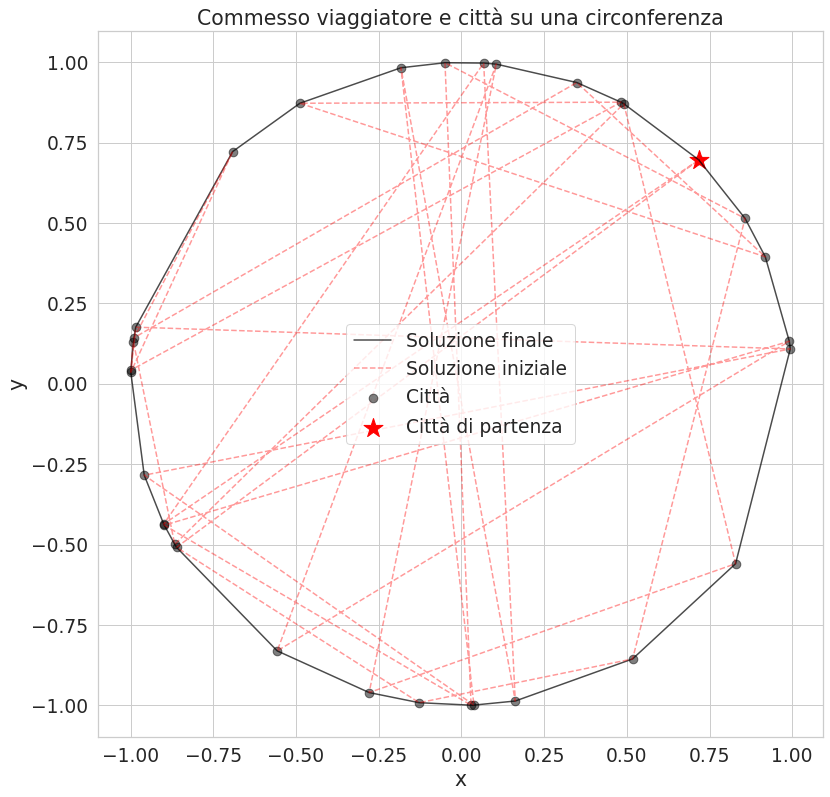

In [4]:
plt.figure(figsize=(13,13))
plt.title("Commesso viaggiatore e città su una circonferenza")
plt.scatter(cities_circ.T[0], cities_circ.T[1], marker='.', s=300, alpha=0.5, color='black', linestyle='-', label='Città')
plt.scatter(cities_circ.T[0][0], cities_circ.T[1][0], marker='*', s=400, alpha=1, color='red', linestyle='-', label='Città di partenza')
plt.plot(x_best, y_best, linestyle='-', alpha=0.7, color='black', label='Soluzione finale')
plt.plot(x_first, y_first, linestyle='--', alpha=0.4, color='red', label='Soluzione iniziale')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('on_circle.png')

plt.show()

__Figura 1:__ in questo grafico sono messe a confronto la soluzione di partenza (in rosso) e la soluzione ottenuta al termine del _simulated annealing_ (in nero). Notiamo che è la stessa ottenuta nell'esercitazione nove.

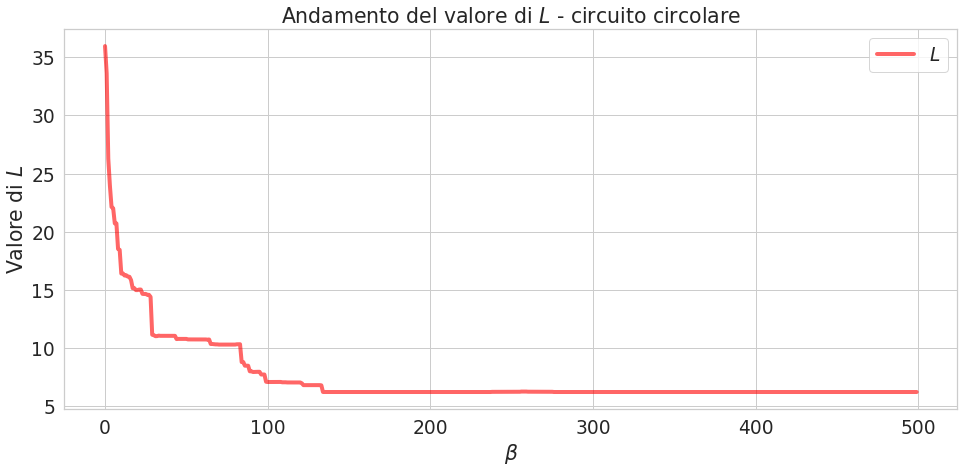

In [5]:
plt.figure(figsize=(16,7))

plt.title("Andamento del valore di $L$ - circuito circolare")
plt.plot(ann_cir, linewidth=4, label="$L$", alpha=0.6, color='red')
plt.xlabel(r'$\beta$')
plt.ylabel('Valore di $L$')
plt.legend()
plt.show()

__Figura 2:__ andamento del valore della funzione di costo valutata sulla soluzione trovata al termine del processo di _simulated annealing_ ad una certa temperatura fissata in funzione del valore di $\beta$. Notiamo che a partire da $\beta \simeq 140$ il sistema non accetta più modifiche alla soluzione ottimale.

Riporto i valori della funzione di costo relativi alla soluzione iniziale e a quella finale:

$$ L_i = 45.0124 $$ 

$$ L_f = 6.2403 $$

### Nel quadrato

In [6]:
cities_sq = np.loadtxt("Results/square_circuit.dat")
chromo1_sq = np.loadtxt("Results/square_ini.dat", dtype='int')
chromo2_sq = np.loadtxt("Results/square_fin.dat", dtype='int')
ann_sq = np.loadtxt("Results/anneal_square.dat")

In [7]:
x_first = [] 
y_first = []

for i in range(len(chromo1_sq)):
    x_first.append(cities_sq.T[0][chromo1_sq[i]-1])
    y_first.append(cities_sq.T[1][chromo1_sq[i]-1])
    
x_first.append(cities_sq.T[0][chromo1_sq[0]-1])
y_first.append(cities_sq.T[1][chromo1_sq[0]-1])

x_best = [] 
y_best = []

for i in range(len(chromo2_sq)):
    x_best.append(cities_sq.T[0][chromo2_sq[i]-1])
    y_best.append(cities_sq.T[1][chromo2_sq[i]-1])
    
x_best.append(cities_sq.T[0][chromo2_sq[0]-1])
y_best.append(cities_sq.T[1][chromo2_sq[0]-1])

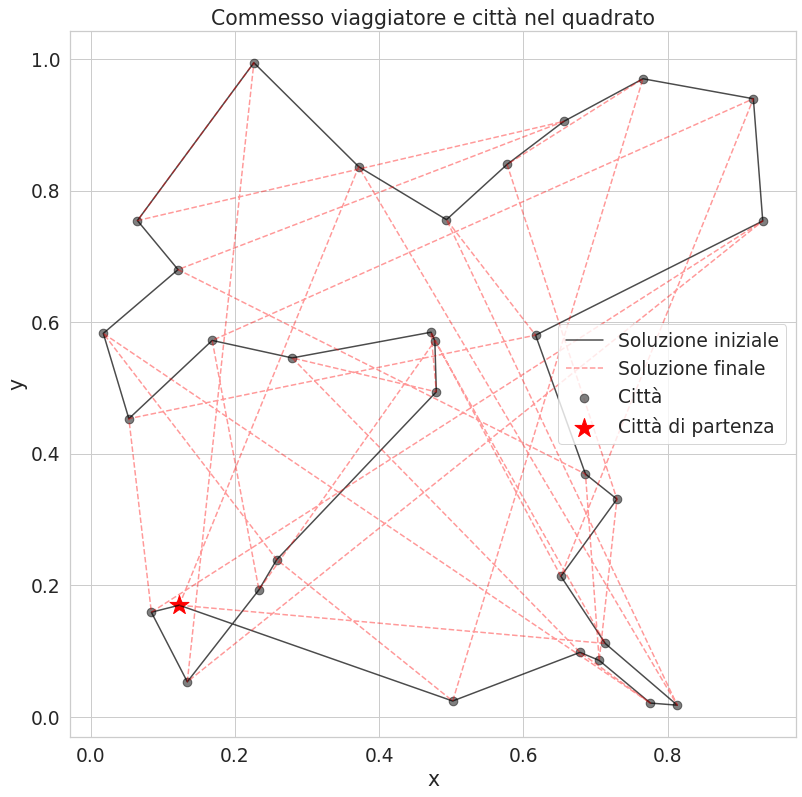

In [8]:
plt.figure(figsize=(13,13))
plt.title("Commesso viaggiatore e città nel quadrato")
plt.scatter(cities_sq.T[0], cities_sq.T[1], marker='.', s=300, alpha=0.5, color='black', linestyle='-', label='Città')
plt.scatter(cities_sq.T[0][0], cities_sq.T[1][0], marker='*', s=400, alpha=1, color='red', linestyle='-', label='Città di partenza')
plt.plot(x_best, y_best, linestyle='-', alpha=0.7, color='black', label='Soluzione iniziale')
plt.plot(x_first, y_first, linestyle='--', alpha=0.4, color='red', label='Soluzione finale')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('on_circle.png')

plt.show()

__Figura 3:__ in rosso, percorso corrispondente alla prima soluzione proposta nell'algoritmo. In nero, il percorso corrispondente alla soluzione finale ottenuta tramite _simulated annealing_.

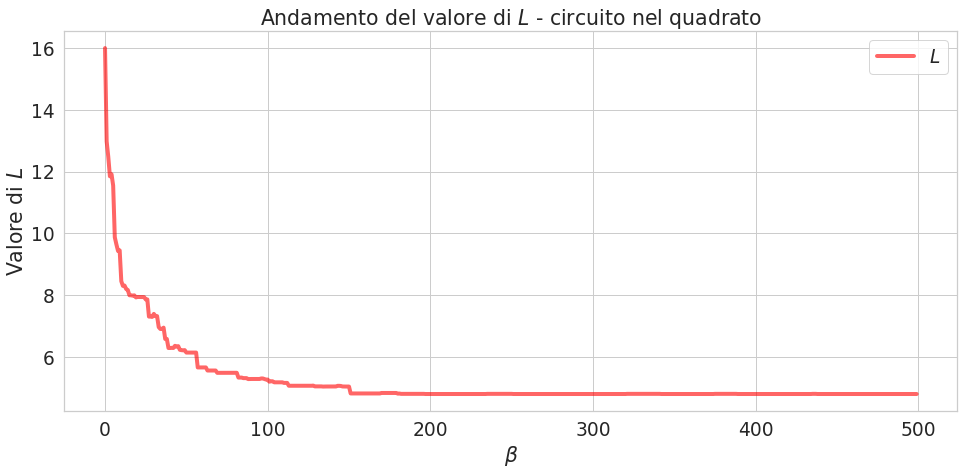

In [9]:
plt.figure(figsize=(16,7))

plt.title("Andamento del valore di $L$ - circuito nel quadrato")
plt.plot(ann_sq, linewidth=4, label="$L$", alpha=0.6, color='red')
plt.xlabel(r'$\beta$')
plt.ylabel('Valore di $L$')
plt.legend()
plt.show()

__Figura 4:__ andamento del valore della funzione di costo valutata sulla soluzione trovata al termine del processo di _simulated annealing_ ad una certa temperatura fissata in funzione del valore di $\beta$. Notiamo che a partire da $\beta \simeq 160$ il sistema non accetta più modifiche alla soluzione ottimale (che non è ancora quella migliore di tutte perché due segmenti si incrociano).

Riporto i valori della funzione di costo relativi alla soluzione iniziale e a quella finale:

$$ L_i = 17.6543 $$ 

$$ L_f = 4.79441 $$

## 10.2 - parallelizzazione del codice GA

In questa seconda parte dell'esercizio modifichiamo il codice scritto per l'esercitazione nove con l'intenzione di parallelizzarne le operazioni. Per farlo, utilizziamo la libreria MPI e sfruttiamo tutti i _threads_ forniti dal processore del mio compilatore ($N_{th}=4$). Affrontando il problema del commesso viaggiatore avevo deciso di soprannominare "Jim" il commesso che si occupava della visita alle città. In analogia con quanto fatto in precedenza ho voluto soprannominare in modo diverso l'operato dei quattro _threads_: in modo che sia chiaro quanto scritto di seguito, li ho chiamati "Jim", "John", "Al" e "Jack". Con questi nomi mi riferisco ai processori con identificativo $i=0,1,2,3$ rispettivamente.

Per trarre un effettivo guadagno dal lavoro contemporaneo dei quattro commessi viaggiatori abbiamo bisogno che cooperino, sfruttando i miglioramenti apportati dagli altri. Ho dunque strutturato l'esecuzione nel modo seguente:

1. ho inizializzato il codice alla parallelizzazione, utilizzando gli opportuni comandi di MPI;
2. ho definito un vettore di quattro elementi, che chiamo `idx[]` ,contenente gli identificatori dei quattro threads;
3. impostato i commessi viaggiatori in modo che l'apprendimento di ciascuno coinvolga `Npop = 1000` cromosomi (soluzioni) e che operino tutti e quattro sullo stesso circuito;
2. per `i < Nstep` volte:
    1. faccio rimescolare da Jim (i=0) il vettore `idx[]` e informo gli altri processori del contenuto del vettore tramite il metodo `MPI_Bcast`;
    2. eseguo `Nswap` generazioni dell'algoritmo genetico;
    3. tramite un'opportuna combinazione delle operazioni `MPI_Send` e `MPI_Recv` e sfruttando la composizione di `idx[]` scambio, a coppie, la soluzione migliore trovata dai commessi viaggiatori;
    4. eseguo un _sorting_ della popolazione relativa ai quattro commessi;
    5. eseguo `i += Nswap`, così che in totale io svolga `Nstep` ricambi generazionali per ogni commesso viaggiatore.
    
---

Nelle seguenti simulazioni ho impostato `Npop = 1000`, `Nstep = 1000`, `Nswap = 10`.

In [81]:
circuit = np.loadtxt("Code/10.2/square_circuit.dat")
jim_f  = np.loadtxt("Code/10.2/best_found_byJim.dat", dtype='int')
al_f   = np.loadtxt("Code/10.2/best_found_byAl.dat", dtype='int')
john_f = np.loadtxt("Code/10.2/best_found_byJohn.dat", dtype='int')
jack_f = np.loadtxt("Code/10.2/best_found_byJack.dat", dtype='int')
jim_i  = np.loadtxt("Code/10.2/first_found_byJim.dat", dtype='int')
al_i   = np.loadtxt("Code/10.2/first_found_byAl.dat", dtype='int')
john_i = np.loadtxt("Code/10.2/first_found_byJohn.dat", dtype='int')
jack_i = np.loadtxt("Code/10.2/first_found_byJack.dat", dtype='int')

In [82]:
def prepare_data(init, final, ncities):
    
    x_first = [] 
    y_first = []

    for i in range(len(ncities)):
        x_first.append(circuit.T[0][init[i]-1])
        y_first.append(circuit.T[1][init[i]-1])
    
    x_first.append(circuit.T[0][init[0]-1])
    y_first.append(circuit.T[1][init[0]-1])

    x_best = [] 
    y_best = []

    for i in range(len(ncities)):
        x_best.append(circuit.T[0][final[i]-1])
        y_best.append(circuit.T[1][final[i]-1])
    
    x_best.append(circuit.T[0][final[0]-1])
    y_best.append(circuit.T[1][final[0]-1])
    
    return x_first, y_first, x_best, y_best

In [83]:
JIM  = prepare_data(jim_i, jim_f, circuit)
AL   = prepare_data(al_i, al_f, circuit)
JOHN = prepare_data(john_i, john_f, circuit)
JACK = prepare_data(jack_i, jack_f, circuit)

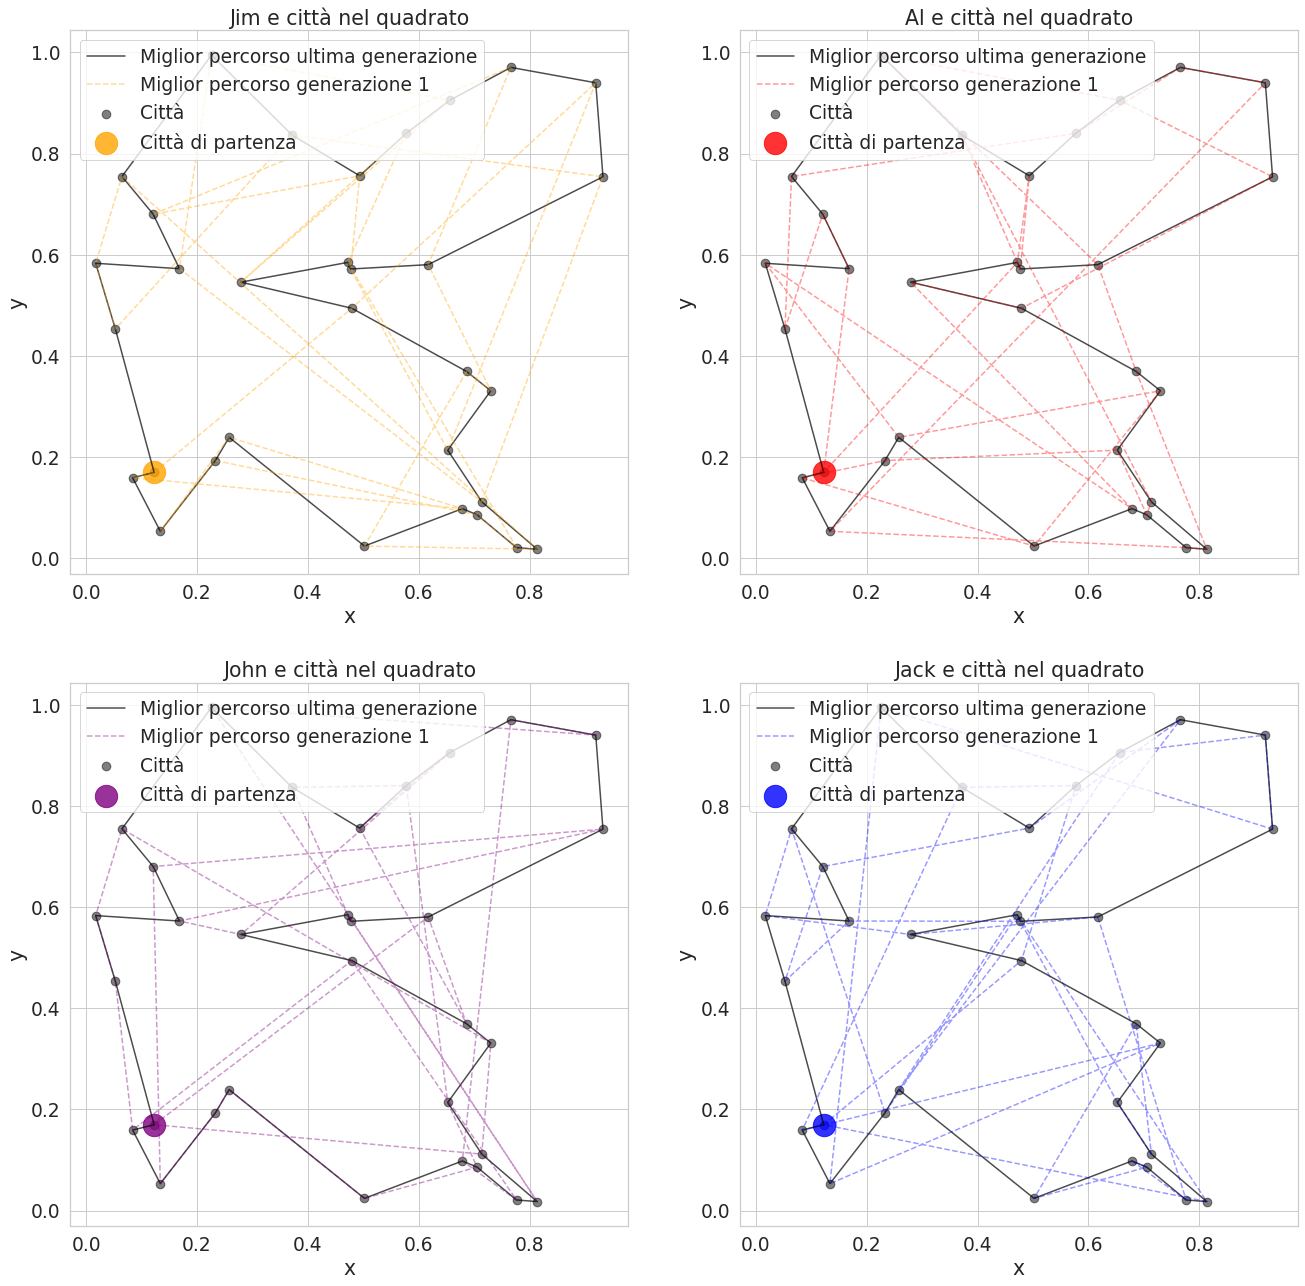

In [84]:
plt.figure(figsize=(22,22))

plt.subplot(2,2,1)
plt.title("Jim e città nel quadrato")
plt.scatter(circuit.T[0], circuit.T[1], marker='.', s=300, alpha=0.5, color='black', linestyle='-', label='Città')
plt.plot(JIM[2], JIM[3], linestyle='-', alpha=0.7, color='black', label='Miglior percorso ultima generazione')
plt.plot(JIM[0], JIM[1], linestyle='--', alpha=0.4, color='orange', label='Miglior percorso generazione 1')
plt.scatter(circuit.T[0][0], circuit.T[1][0], marker='.', s=2000, alpha=0.8, color='orange', linestyle='-', label='Città di partenza')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(2,2,2)
plt.title("Al e città nel quadrato")
plt.scatter(circuit.T[0], circuit.T[1], marker='.', s=300, alpha=0.5, color='black', linestyle='-', label='Città')
plt.plot(AL[2], AL[3], linestyle='-', alpha=0.7, color='black', label='Miglior percorso ultima generazione')
plt.plot(AL[0], AL[1], linestyle='--', alpha=0.4, color='red', label='Miglior percorso generazione 1')
plt.scatter(circuit.T[0][0], circuit.T[1][0], marker='.', s=2000, alpha=0.8, color='red', linestyle='-', label='Città di partenza')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(2,2,3)
plt.title("John e città nel quadrato")
plt.scatter(circuit.T[0], circuit.T[1], marker='.', s=300, alpha=0.5, color='black', linestyle='-', label='Città')
plt.plot(JOHN[2], JOHN[3], linestyle='-', alpha=0.7, color='black', label='Miglior percorso ultima generazione')
plt.plot(JOHN[0], JOHN[1], linestyle='--', alpha=0.4, color='purple', label='Miglior percorso generazione 1')
plt.scatter(circuit.T[0][0], circuit.T[1][0], marker='.', s=2000, alpha=0.8, color='purple', linestyle='-', label='Città di partenza')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(2,2,4)
plt.title("Jack e città nel quadrato")
plt.scatter(circuit.T[0], circuit.T[1], marker='.', s=300, alpha=0.5, color='black', linestyle='-', label='Città')
plt.plot(JACK[2], JACK[3], linestyle='-', alpha=0.7, color='black', label='Miglior percorso ultima generazione')
plt.plot(JACK[0], JACK[1], linestyle='--', alpha=0.4, color='blue', label='Miglior percorso generazione 1')
plt.scatter(circuit.T[0][0], circuit.T[1][0], marker='.', s=2000, alpha=0.8, color='blue', linestyle='-', label='Città di partenza')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.savefig("JAJJ.png")
plt.show()

__Figura 5:__ nelle quattro figure sono raffigurati i circuiti corrispondenti alla miglior soluzione della prima generazione di cromosomi per i quattro commessi viaggiatori (linee colorate e tratteggiate) e la miglior soluzione dell'ultima generazione di cromosomi (linee nere). Si nota che le soluzioni trovate nella prima generazione sono tutte differenti, al contrario, la soluzione finale è la stessa in tutti e quattro i casi. Questo è dovuto al fatto che uno tra i quattro commessi viaggiatori (osservando la figura 6 si capisce che si tratta di Jack) è il primo a trovare la soluzione migliore e, nel corso dei successivi passi dell'algoritmo, questa soluzione viene adottata come la migliore anche dagli altri commessi viaggiatori.

$$ L_{i}^{(Jim)} = 12.685\qquad L_f^{(Jim)} = 4.80339 $$

$$ L_{i}^{(Al)} = 12.3208 \qquad L_f^{(Al)} = 4.80339 $$

$$ L_{i}^{(John)} = 12.6326\qquad L_f^{(John)} = 4.80339 $$

$$ L_{i}^{(Jack)} = 13.0696\qquad L_f^{(Jack)} = 4.80339 $$

In [92]:
best_jim  = np.loadtxt("Code/10.2/best1.dat")
best_al   = np.loadtxt("Code/10.2/best2.dat") 
best_john = np.loadtxt("Code/10.2/best3.dat")
best_jack = np.loadtxt("Code/10.2/best4.dat")

half_jim  = np.loadtxt("Code/10.2/best_half1.dat")
half_al   = np.loadtxt("Code/10.2/best_half2.dat")
half_john = np.loadtxt("Code/10.2/best_half3.dat")
half_jack = np.loadtxt("Code/10.2/best_half4.dat")

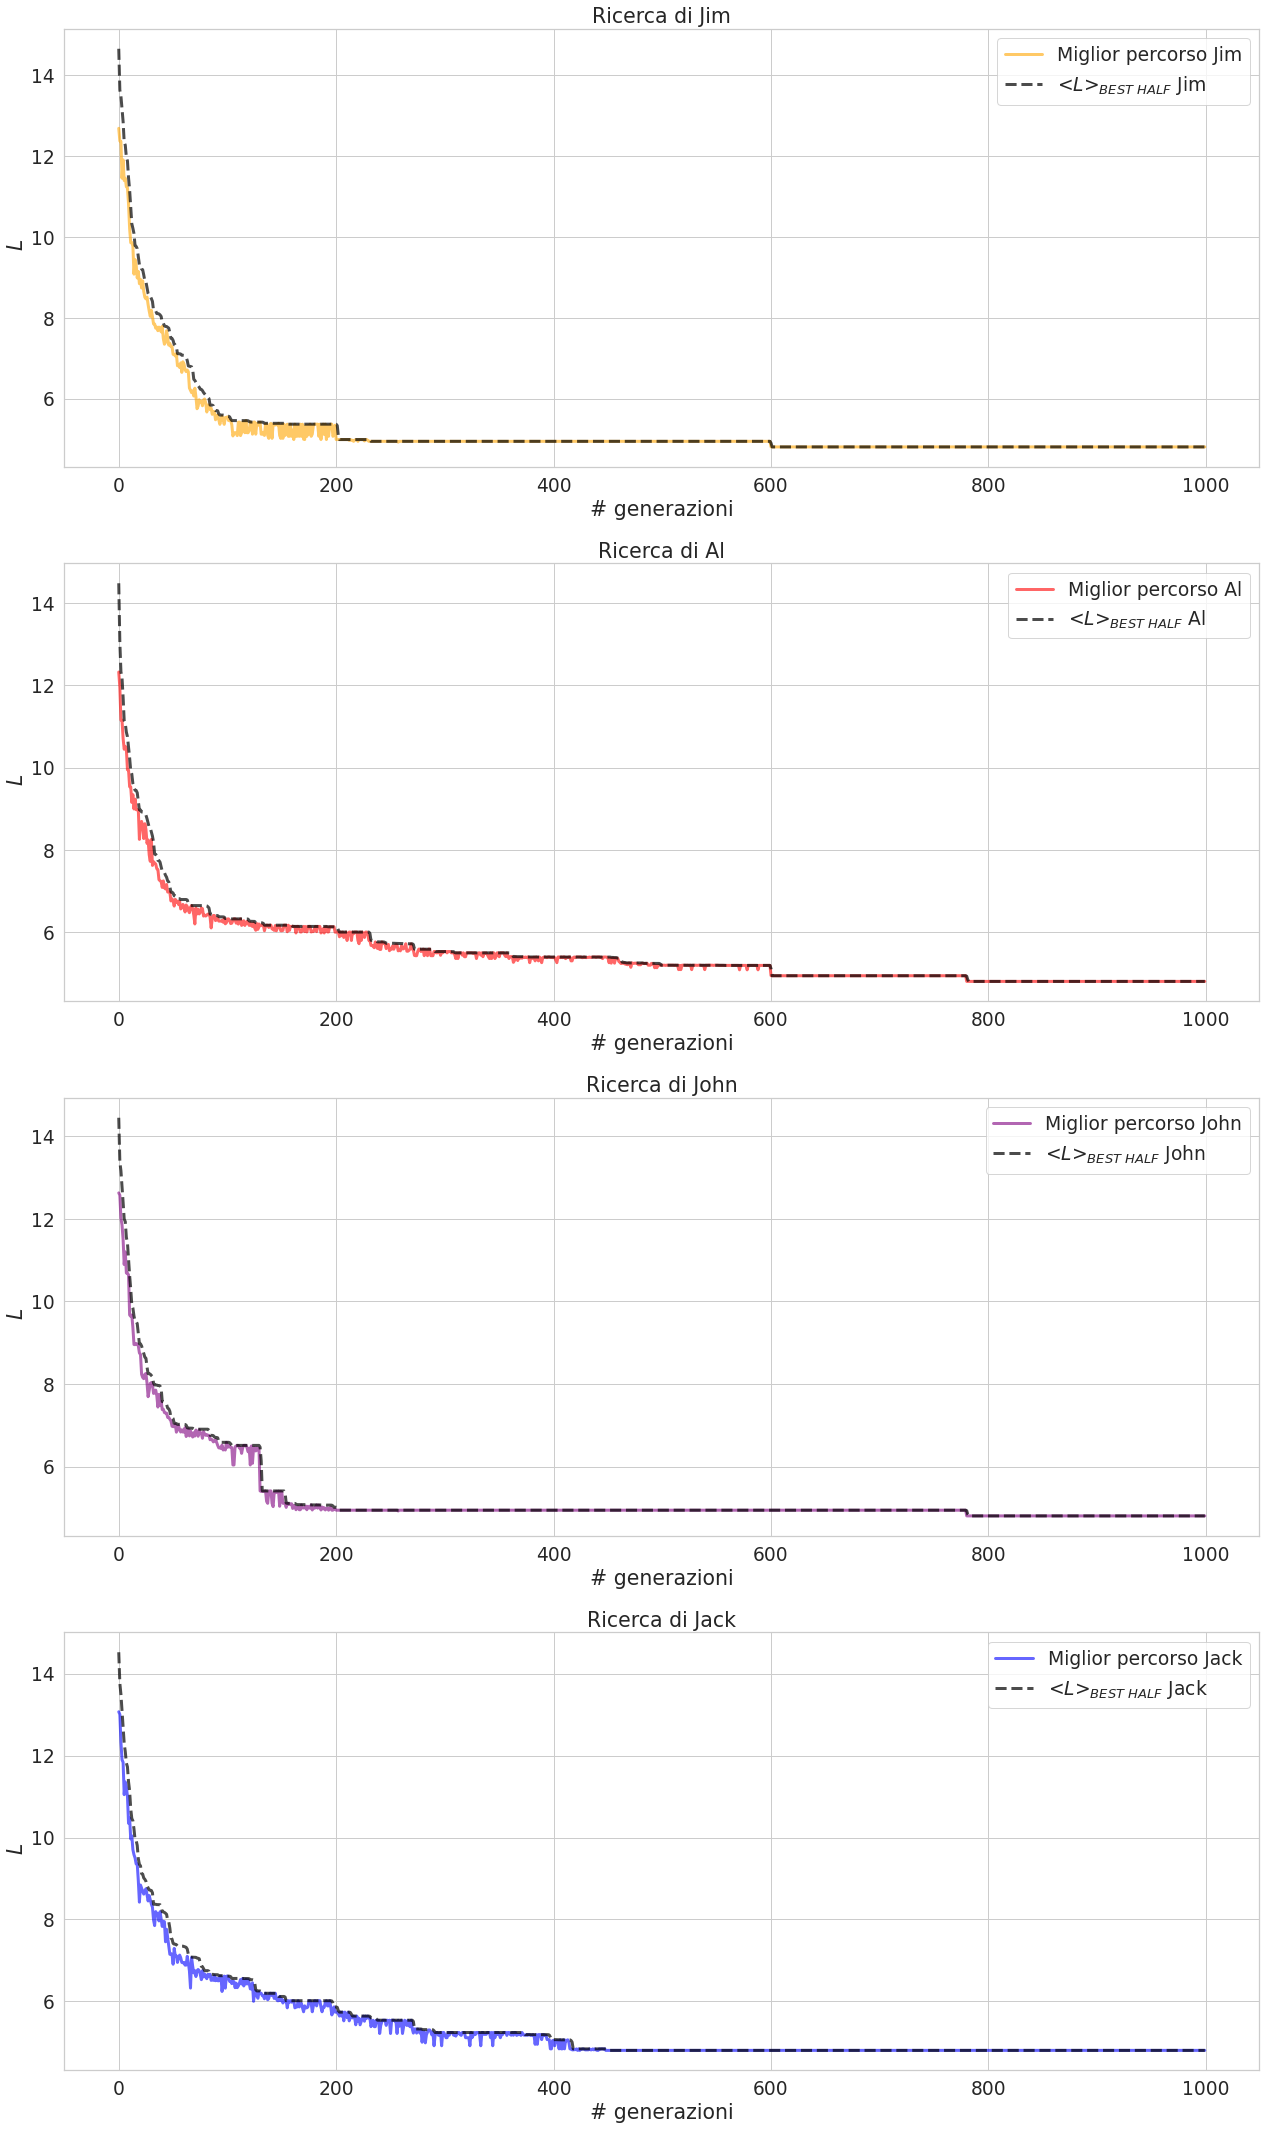

In [91]:
plt.figure(figsize=(18,30))

plt.subplot(4,1,1)
plt.title("Ricerca di Jim")
plt.plot(best_jim[600:], linestyle='-', label='Miglior percorso Jim', color='orange', alpha=0.6, linewidth=3)
plt.plot(half_jim[600:], linestyle='--', label='<$L$>$_{BEST\,\,HALF}$ Jim', color='black', alpha=0.7, linewidth=3)
plt.xlabel("# generazioni")
plt.ylabel(" $L$")
plt.legend()

plt.subplot(4,1,2)
plt.title("Ricerca di Al")
plt.plot(best_al[600:], linestyle='-', label='Miglior percorso Al', color='red', alpha=0.6, linewidth=3)
plt.plot(half_al[600:], linestyle='--', label='<$L$>$_{BEST\,\,HALF}$ Al', color='black', alpha=0.7, linewidth=3)
plt.xlabel("# generazioni")
plt.ylabel(" $L$")
plt.legend()

plt.subplot(4,1,3)
plt.title("Ricerca di John")
plt.plot(best_john[600:], linestyle='-', label='Miglior percorso John', color='purple', alpha=0.6, linewidth=3)
plt.plot(half_john[600:], linestyle='--', label='<$L$>$_{BEST\,\,HALF}$ John', color='black', alpha=0.7, linewidth=3)
plt.xlabel("# generazioni")
plt.ylabel(" $L$")
plt.legend()

plt.subplot(4,1,4)
plt.title("Ricerca di Jack")
plt.plot(best_jack[600:], linestyle='-', label='Miglior percorso Jack', color='blue', alpha=0.6, linewidth=3)
plt.plot(half_jack[600:], linestyle='--', label='<$L$>$_{BEST\,\,HALF}$ Jack', color='black', alpha=0.7, linewidth=3)
plt.xlabel("# generazioni")
plt.ylabel(" $L$")
plt.legend()

plt.tight_layout()
plt.show()

__Figura 6:__ in queste ultime quattro figure ho rappresentato l'andamento della funzione di costo corrispondente al miglior individuo della popolazione trattata dai quattro commessi viaggiatori in funzione del numero di generazioni (curve colorate) e la media dei valori della $L$ calcolati considerando la miglior metà della popolazione per ogni commesso viaggiatore, in funzione del numero di generazioni. Dopo aver superato una prima fase di miglioramento generale e indipendente, si nota che è uno dei quattro commessi viaggiatori a trovare per primo quella che verrà poi condivisa come soluzione migliore.

Ho notato che in termini di tempo di calcolo e di performance questo algoritmo è piuttosto simile al caso in cui il codice non era parallelizzato. Va detto che lo abbiamo testato su un problema piuttosto semplice: forse 32 città non  sono sufficienti per mettere alla prova le potenzialità del passaggio ad un codice parallelizzato. Nonostante questo, notiamo che i quattro commessi viaggiatori raggiungono una soluzione nel quadrato migliore di quella ottenuta nell'esercitazione nove.